## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Opening JSON file 
f = open('/content/gdrive/MyDrive/complaints-2021-05-14_08_16.json') # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [5]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [6]:
#Assign new column names
df.columns = ["index","type","id","score","tags","zip_code","complaint_id","issue","date_received","state","consumer_disputed","product","company_response","company","submitted_via","date_sent_to_company","company_public_response","sub_product","timely","complaint_what_happened","sub_issue","consumer_consent_provided"]

In [7]:
#Assign nan in place of blanks in the complaints column
df[df['complaint_what_happened']== ""] =np.nan

In [8]:
df['complaint_what_happened']

0                                                      NaN
1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                      NaN
4                                                      NaN
                               ...                        
78308                                                  NaN
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 78313, dtype: object

In [9]:
#Remove all rows where complaints column is nan
df=df.dropna(subset=['complaint_what_happened'])

In [10]:
df['complaint_what_happened']

1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
10       Chase Card was reported on XX/XX/2019. However...
11       On XX/XX/2018, while trying to book a XXXX  XX...
14       my grand son give me check for {$1600.00} i de...
                               ...                        
78303    After being a Chase Card customer for well ove...
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 21072, dtype: object

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [11]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean(data):
  data = data.lower()
  data = re.sub(r'\[.*?\]', '', data)
  data = re.sub(r'[%s]' % re.escape(string.punctuation), '', data)
  data = re.sub(r'\w*\d\w*', '', data)
  return data

df_clean = pd.DataFrame(df['complaint_what_happened'].apply(lambda x: clean(x)))

In [12]:
df_clean

,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...
...,...
78303,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs ive had ch...


In [13]:
#Write your function to Lemmatize the texts
def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

In [14]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean["Complaint_lemmatize"]=df_clean.apply(lambda x: lemmatizer(x['complaint_what_happened']), axis=1)

In [15]:
df_clean

,complaint_what_happened,Complaint_lemmatize
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...


In [16]:
#Write your function to extract the POS tags 
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from textblob import TextBlob

def pos_tag(text):
    blob = TextBlob(text)
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])



df_clean["complaint_POS_removed"] = df_clean.apply(lambda x: pos_tag(x['Complaint_lemmatize']), axis = 1) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [17]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...,credit yr credit card chase freedom xxxx probl...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




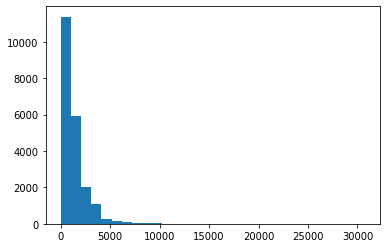

In [18]:
# Write your code here to visualise the data according to the 'Complaint' character length

length = [len(word) for word in df_clean['complaint_what_happened']]

plt.hist(length, bins =30)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

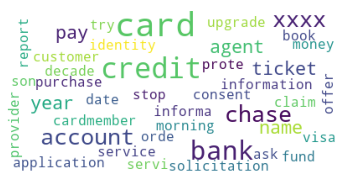

In [19]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=40,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [20]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [21]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df_clean['Complaint_clean'].values.astype('U'), 50)
df1 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df1['unigram'], y=df1['count'])])
fig.update_layout(title=go.layout.Title(text="Top 50 unigrams in the Complaint text after removing stop words and lemmatization"))
fig.show()

In [22]:
#Print the top 10 words in the unigram frequency
df1.head(10)

,unigram,count
0,account,47492
1,chase,46693
2,xxxx,36531
3,credit,34132
4,card,29279
5,bank,28408
6,payment,21167
7,time,16033
8,charge,14991
9,day,12966


In [23]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
def get_top_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range= (2,2),stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_bigrams(df_clean['Complaint_clean'].values.astype('U'), 50)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top 50 unigrams in the Complaint text after removing stop words and lemmatization"))
fig.show()

In [24]:
#Print the top 10 words in the bigram frequency
df2.head(10)

,unigram,count
0,credit card,12779
1,credit report,4003
2,xxxx xxxx,3931
3,customer service,3079
4,chase credit,2967
5,chase bank,2944
6,bank account,2778
7,chase account,2619
8,account chase,2595
9,account account,2414


In [25]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
def get_top_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range= (3,3),stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_trigrams(df_clean['Complaint_clean'].values.astype('U'), 50)
df3 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df3['unigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 50 unigrams in the Complaint text after removing stop words and lemmatization"))
fig.show()

In [26]:
#Print the top 10 words in the trigram frequency
df3.head(10)

,unigram,count
0,chase credit card,2063
1,credit card account,1026
2,credit card company,990
3,credit card chase,634
4,credit card credit,514
5,inquiry credit report,480
6,charge credit card,422
7,xxxx xxxx xxxx,410
8,account credit card,401
9,card credit card,388


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [27]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [28]:
#All masked texts has been removed
df_clean

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...,credit yr credit card chase freedom xxxx probl...,credit yr credit card chase freedom problem b...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [29]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [30]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [31]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [32]:
#Load your nmf_model with the n_components i.e 5

#keep the random_state =40
nmf_model = NMF(n_components =5, random_state =40) #write your code here

In [33]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



7257

In [34]:
#Print the top word of a sample component
single_topic = nmf_model.components_[0]
single_topic.argsort()
top_word_indices = single_topic.argsort()[-10:]
for index in top_word_indices:
    print(tfidf.get_feature_names()[index])

number
day
branch
deposit
chase
fund
money
check
bank
account


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [35]:
#Print the Top15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['transfer', 'claim', 'checking', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'check', 'bank', 'account']


THE TOP 15 WORDS FOR TOPIC #1
['balance', 'year', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


THE TOP 15 WORDS FOR TOPIC #2
['mortgage', 'year', 'chase', 'account', 'credit', 'pay', 'date', 'auto', 'time', 'day', 'statement', 'fee', 'month', 'balance', 'payment']


THE TOP 15 WORDS FOR TOPIC #3
['company', 'refund', 'statement', 'time', 'service', 'claim', 'purchase', 'fraud', 'merchant', 'chase', 'dispute', 'transaction', 'fee', 'card', 'charge']


THE TOP 15 WORDS FOR TOPIC #4
['sale', 'foreclosure', 'house', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'chase', 'modification', 'home', 'mortgage', 'loan']




In [36]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)


array([0, 1, 1, ..., 3, 2, 2])

In [37]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1) #write your code to assign topics to each rows.

In [38]:
df_clean

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,3
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,3
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...,credit yr credit card chase freedom xxxx probl...,credit yr credit card chase freedom problem b...,2


In [39]:
#Print the first 5 Complaint for each of the Topics
df_clean5=df_clean.groupby('Topic').head(5)
df_clean5.sort_values('Topic')

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [40]:
#Create the dictionary of Topic names and Topics
Topic_names = {0:"Bank Account services",1:"Credit card or prepaid card", 2:"Others",3:"Theft/Dispute Reporting",4:"Mortgage/Loan"}

In [41]:
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [42]:
df_clean

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Bank Account services
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Credit card or prepaid card
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit card or prepaid card
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank Account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,Theft/Dispute Reporting
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,Theft/Dispute Reporting
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...,credit yr credit card chase freedom xxxx probl...,credit yr credit card chase freedom problem b...,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [43]:
#Create the dictionary again of Topic names and Topics
Topic_names = {"Bank Account services":0,"Credit card or prepaid card":1,"Others":2,"Theft/Dispute Reporting":3,"Mortgage/Loan":4}


In [44]:
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [45]:
df_clean

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,3
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,3
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...,credit yr credit card chase freedom xxxx probl...,credit yr credit card chase freedom problem b...,2


In [46]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened', 'Topic']]

In [47]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in and was told ...,1
10,chase card was reported on however fraudulent...,1
11,on while trying to book a xxxx xxxx ticket ...,1
14,my grand son give me check for i deposit it i...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs ive had ch...,2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [48]:
#Write your code to get the Vector count
import pickle 
from sklearn.feature_extraction.text import TfidfTransformer

cv = CountVectorizer()
X_train_counts = cv.fit_transform(training_data['complaint_what_happened'])

#Write your code here to transform the word vector to tf-idf
tfidf_transform  = TfidfTransformer()
X_train_tfidf = tfidf_transform.fit_transform(X_train_counts)

In [49]:
X_train_tfidf

<21072x33599 sparse matrix of type '<class 'numpy.float64'>'
	with 2280807 stored elements in Compressed Sparse Row format>

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [50]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
NB = MultinomialNB().fit(X_train, y_train)



In [51]:
y_pred_nb = NB.predict(X_test)

In [52]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

f1_nb = f1_score(y_test, y_pred_nb, average="weighted")
f1_nb

0.6775149662078727

In [53]:
def cf_matrix(y_test, y_pred):
  matrix = confusion_matrix(y_test, y_pred)
  sns.heatmap(matrix, annot=True, cbar=None, cmap="Blues", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting","Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting","Mortgage/Loan"])

In [54]:
def evaluation(y_test, y_pred):
  target_names = ["Bank Account services","Credit card or prepaid card","Mortgage/Loan","Theft Reporting","Others"]
  print(classification_report(y_test, y_pred, target_names=target_names))

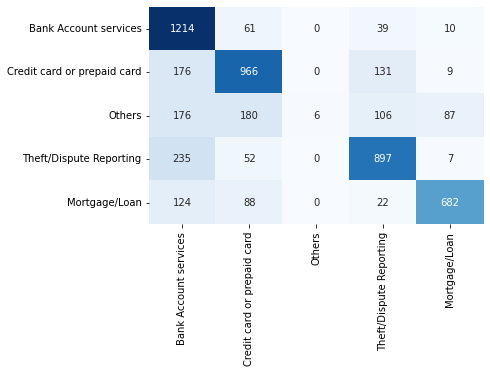

In [55]:
cf_matrix(y_test, y_pred_nb)

In [56]:
evaluation(y_test, y_pred_nb)

                             precision    recall  f1-score   support

      Bank Account services       0.63      0.92      0.75      1324
Credit card or prepaid card       0.72      0.75      0.73      1282
              Mortgage/Loan       1.00      0.01      0.02       555
            Theft Reporting       0.75      0.75      0.75      1191
                     Others       0.86      0.74      0.80       916

                   accuracy                           0.71      5268
                  macro avg       0.79      0.64      0.61      5268
               weighted avg       0.76      0.71      0.68      5268



In [57]:
# logistic regression 
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression().fit(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [58]:
y_pred_lr = log_reg.predict(X_test)

In [59]:
f1_lr= f1_score(y_test, y_pred_lr, average="weighted")
f1_lr

0.9253986091512919

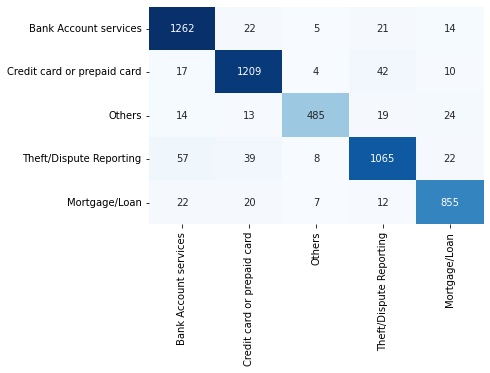

In [60]:
cf_matrix(y_test, y_pred_lr)

In [61]:
evaluation(y_test, y_pred_lr)

                             precision    recall  f1-score   support

      Bank Account services       0.92      0.95      0.94      1324
Credit card or prepaid card       0.93      0.94      0.94      1282
              Mortgage/Loan       0.95      0.87      0.91       555
            Theft Reporting       0.92      0.89      0.91      1191
                     Others       0.92      0.93      0.93       916

                   accuracy                           0.93      5268
                  macro avg       0.93      0.92      0.92      5268
               weighted avg       0.93      0.93      0.93      5268



In [62]:
#decision tree
from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [63]:
y_pred_dt = clf_dt.predict(X_test)

In [64]:
f1_dt=f1_score(y_test, y_pred_dt, average="weighted")
f1_dt

0.7845720188233289

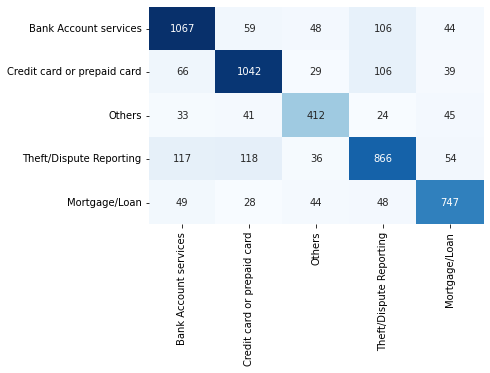

In [65]:
cf_matrix(y_test, y_pred_dt)

In [66]:
evaluation(y_test, y_pred_dt)

                             precision    recall  f1-score   support

      Bank Account services       0.80      0.81      0.80      1324
Credit card or prepaid card       0.81      0.81      0.81      1282
              Mortgage/Loan       0.72      0.74      0.73       555
            Theft Reporting       0.75      0.73      0.74      1191
                     Others       0.80      0.82      0.81       916

                   accuracy                           0.78      5268
                  macro avg       0.78      0.78      0.78      5268
               weighted avg       0.78      0.78      0.78      5268



In [69]:
#random forest
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)

RandomForestClassifier()

In [70]:
y_pred_rf = clf_rf.predict(X_test)

In [71]:
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
f1_rf

0.8134339567098182

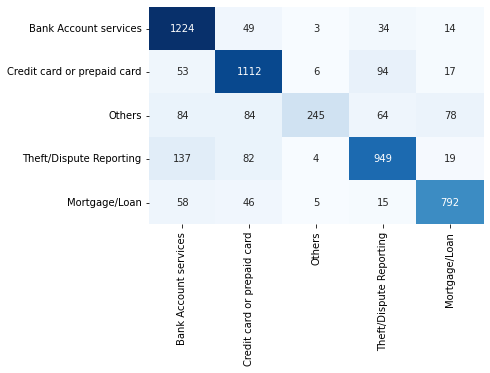

In [72]:
cf_matrix(y_test, y_pred_rf)

In [73]:
evaluation(y_test, y_pred_rf)

                             precision    recall  f1-score   support

      Bank Account services       0.79      0.92      0.85      1324
Credit card or prepaid card       0.81      0.87      0.84      1282
              Mortgage/Loan       0.93      0.44      0.60       555
            Theft Reporting       0.82      0.80      0.81      1191
                     Others       0.86      0.86      0.86       916

                   accuracy                           0.82      5268
                  macro avg       0.84      0.78      0.79      5268
               weighted avg       0.83      0.82      0.81      5268



0.6775 --- naive bayes  

0.9253--- logistic regression 

0.7845 --- decision tree 

0.8134 --- random forest 


logistic regression is the best model.